In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import detectron2
import torch
import numpy as np
import cv2 
import os
import matplotlib.pyplot as plt
import matplotlib
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
matplotlib.rcParams['figure.dpi']=100
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
from vis_det.model_pool import get_data, get_model
from vis_det.data import query_image,data_preprocessing
from detectron2.utils.visualizer import Visualizer
from vis_det.optimize import layout_optimize, layout_vis_loss

In [5]:
## load data 
coco_val, coco_val_meta = get_data("kitti_semantics")

finish registering kitti_semantics_instance_train to DatasetCatalog.


In [6]:
## load model and corresponding arg, cfg and predictor.
model, args, cfg, predictor = get_model("Cityscapes/mask_rcnn_R_50_FPN")
# model, args, cfg, predictor = get_model("COCO-Detection/retinanet_R_50_FPN")
# model, args, cfg, predictor = get_model("COCO-Detection/faster_rcnn_R_50_FPN")

In [7]:
coco_val[0]

{'file_name': '/home/devenish/Desktop/delight/datasets/kitti_semantics_cs/data_semantics/train/kitti/kitti_000132_10_leftImg8bit.png',
 'image_id': 'kitti_000132_10_leftImg8bit.png',
 'height': 375,
 'width': 1242,
 'annotations': [{'iscrowd': True,
   'category_id': 2,
   'bbox': (498, 174, 644, 196),
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'segmentation': [[519,
     179,
     518,
     180,
     517,
     180,
     516,
     180,
     515,
     181,
     514,
     181,
     513,
     181,
     512,
     181,
     511,
     181,
     510,
     182,
     509,
     182,
     508,
     182,
     507,
     182,
     506,
     182,
     505,
     183,
     504,
     183,
     503,
     183,
     502,
     184,
     501,
     184,
     500,
     184,
     499,
     185,
     498,
     185,
     499,
     185,
     500,
     185,
     501,
     185,
     502,
     185,
     503,
     185,
     504,
     185,
     505,
     184,
     506,
     184,
     507,
     184,
     508,
     184,
 

In [9]:
## load the target image layouts and show.
#target_img = "000000439715"
target_img = coco_val[1]['file_name']
target_image = query_image(target_img, coco_val)
#print(target_image)

/home/devenish/Desktop/delight/datasets/kitti_semantics_cs/data_semantics/train/kitti/kitti_000112_10_leftImg8bit.png


In [15]:
images, gt_instances, mapper_target = data_preprocessing(cfg,target_image,model)


In [16]:
gt_instances

[Instances(num_instances=14, image_height=618, image_width=2048, fields=[gt_boxes: Boxes(tensor([[ 979.,  270.,  986.,  275.],
         [ 972.,  273.,  981.,  280.],
         [ 936.,  286.,  949.,  293.],
         [1578.,  296., 1787.,  352.],
         [ 618.,  306.,  638.,  334.],
         [ 679.,  301.,  700.,  309.],
         [ 621.,  301.,  687.,  337.],
         [ 552.,  306.,  616.,  344.],
         [1896.,  271., 2046.,  382.],
         [ 245.,  290.,  422.,  365.],
         [ 657.,  293.,  908.,  397.],
         [ 860.,  293., 1211.,  614.],
         [  74.,  331.,  316.,  421.],
         [ 916.,  281.,  939.,  291.]], device='cuda:0')), gt_classes: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3], device='cuda:0'), gt_masks: PolygonMasks(num_instances=14)])]

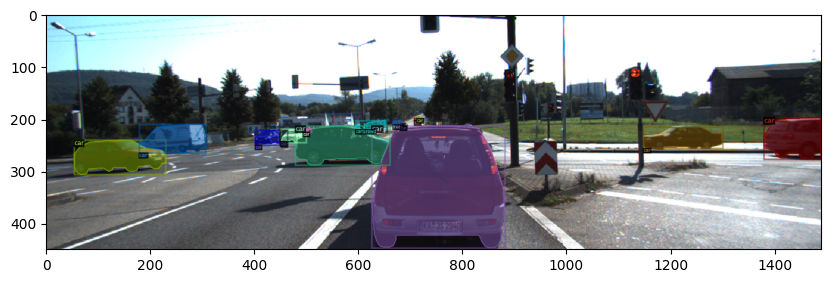

In [17]:
img = cv2.imread(target_image["file_name"])
visualizer = Visualizer(img, metadata=coco_val_meta, scale=1.2)
vis = visualizer.draw_dataset_dict(target_image)
plt.imshow(vis.get_image()[:,:,::-1])

In [18]:
%%time
loss_func = layout_vis_loss(args)
inverter = layout_optimize(args, cfg)
x = inverter.invert(images, gt_instances, model, loss_func)

Into Invert
Mask Invert
Initialization 
iteration 0
iteration 100
iteration 200
iteration 300
iteration 400
iteration 500
iteration 600


Process ForkPoolWorker-3:
Process ForkPoolWorker-2:
Process ForkPoolWorker-4:
Process ForkPoolWorker-1:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/devenish/Desktop/delight/detectron2/detectron2/data/catalog.py", line 51, in get
    f = self[name]
Traceback (most recent call last):
  File "/home/devenish/Desktop/delight/detectron2/detectron2/data/catalog.py", line 51, in get
    f = self[name]
Traceback (most recent call last):
  File "/home/devenish/anaconda3/envs/smcalib/lib/python3.7/collections/__init__.py", line 1027, in __getitem__
    raise KeyError(key)
  File "/home/devenish/Desktop/delight/detectron2/detectron2/data/catalog.py", line 51, in get
    f = self[name]
  File "/home/devenish/anaconda3/envs/smcalib/lib/python3.7/collections/__init__.py", line 1027, in __getitem__
    raise KeyError(key)
KeyError: 'kitti_semantics_instance_train'

The above exception was the direct cause of the following exception:

Traceback (most recent call 

KeyboardInterrupt: 

The GPU memory usage is around 4GB.
CPU times: user 11min 53s, sys: 13.8 s, total: 12min 7s
Wall time: 3min 1s

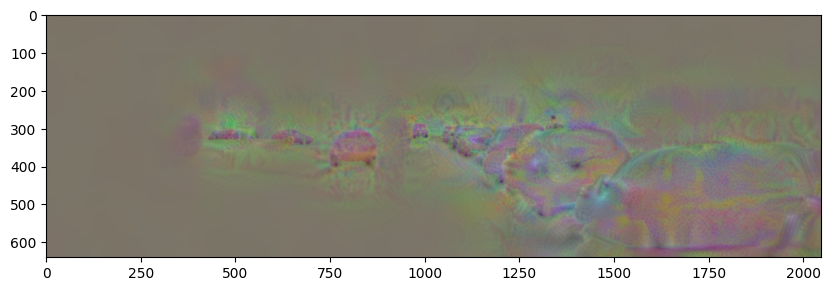

In [9]:
# draw the inverse
inverse_img = inverter.post_processing(x)
plt.imshow(inverse_img[0][:,:,::-1])

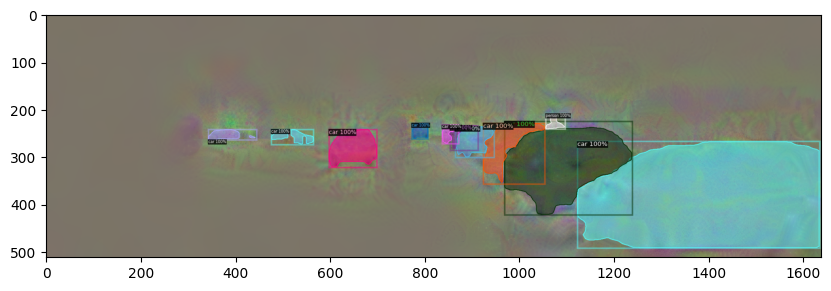

In [10]:
## show the prediction results.
inverse_img = inverse_img[0]
outputs = predictor(inverse_img)
v1 = Visualizer(inverse_img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.8)
v1 = v1.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(v1.get_image())